In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Preparing the Dataset

In [3]:
# Hyperparameters
batch_size = 64
n_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
momentum_sgd = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [4]:
def generate_batch(batch):
    batch_len = len(batch)
    labels = np.zeros((batch_len))
    imgs = []
    for i in range(batch_len):
        img = np.array(batch[i][0])
        target = np.array(batch[i][1])
        labels[i] =  target
        imgs.append(img)
    imgs = torch.as_tensor(imgs, dtype=torch.float)
    labels = torch.as_tensor(labels, dtype=torch.long)
    return imgs, labels

In [5]:
# Since we are using an existing dataset, there is no need to create a custom
# one.

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0], [1])
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/datasets/', train=True, 
                               download=True, 
                               transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=generate_batch)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/datasets/', train=False, 
                               download=True,
                               transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=generate_batch)

In [6]:
examples = enumerate(train_loader)
idx, (data, target) = next(examples)

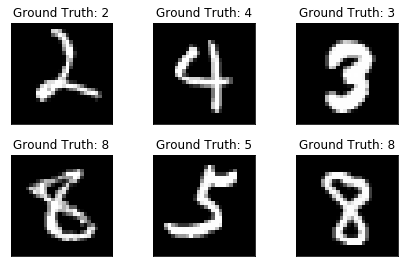

In [32]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(target[i]))
  plt.xticks([])
  plt.yticks([])

## Building the Model

In [31]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) # (num_features, num_classes)
    
    def forward(self, x):
#         print(x.shape)
        
        # This code is taken from guide
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         print(x.shape)
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
#         print(x.shape)
        x = x.view(-1, 320)
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x = F.dropout(x, training=self.training)
#         print(x.shape)
        x = F.relu(self.fc2(x))
#         print(x.shape)
        return F.log_softmax(x, dim=1)

In [25]:
model = ImageClassifier().to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

## Training

In [26]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i+len(train_loader.dataset) for i in range(n_epochs + 1)]

In [31]:
def train_func(epoch):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        if torch.cuda.is_available():
            image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(model.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')
#     scheduler.step()

def test_func():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            if torch.cuda.is_available():
                image, label = image.to(device), label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [32]:
test_func()
for epoch in range(1, n_epochs + 1):
    train_func(epoch)
    test_func()
    scheduler.step()

c:\users\zain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0357, Accuracy: 1657/10000 (16%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300687
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.293427
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293883
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.301066
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.209499
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.199741
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.209574
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.198191
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.183648
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.165638
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.176887
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.094489
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.065310
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.045964
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.134927
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.035128
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.872509
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.848951
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.784042
Train Epoch: 1 [12160

Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.328570
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.202404
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.085587
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.173322
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.214064
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.082201
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.326792
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.186630
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.588775
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.293112
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.300795
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.184847
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.087397
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.403789
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.124519
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.187656
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.119839
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.206376
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.360882
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.276491


Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.264651
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.090462
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.201535
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.384681
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.184529
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.054131
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.137080
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.296276
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.139573

Test set: Avg. loss: 0.0013, Accuracy: 9722/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.315650
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.256740
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.260757
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.288514
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.220208
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.213229
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.112201
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.130391
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.642061
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.288878
Train Epoch: 8 

### Inference plot

Text(0, 0.5, 'negative log likelihood loss')

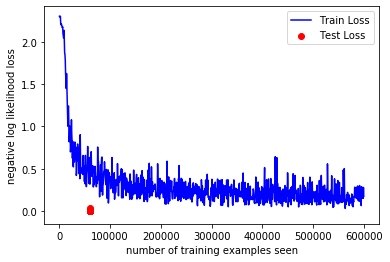

In [33]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


## Testing

In [34]:
model_path = 'results/model.pth'
model = ImageClassifier()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [35]:
def make_predictions(model, data):
    out = model(data)
    pred = out.data.max(1, keepdim=True)[1]
    return pred

examples = enumerate(test_loader)
idx, (data, target) = next(examples)
predictions = make_predictions(model, data)

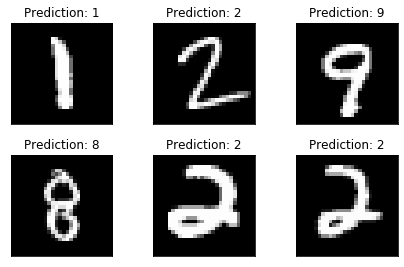

In [37]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(predictions[i].numpy()[0]))
  plt.xticks([])
  plt.yticks([])